# MWS Secondary Target Selection

## MWS_CALIB_GAIAESO

Maintainers:
  - Ting Li (selection/catalog)
  - Andrew Cooper (secondary target code)

In [1]:
ls ../raw

gaiaeso_xm_gaia_4DESI_v0.fits


{ DESCRIPTION NEEDED }

The selection criteria are:

???

In [2]:
pwd

'/global/projecta/projectdirs/desi/external/mws/sv/MWS_CALIB_GAIAESO/1/code'

In [3]:
import os
import numpy as np
from astropy.table import Table, Column
import astropy.io.fits as fits

In [5]:
target_class   = 'MWS_CALIB_GAIAESO'
input_filename = 'gaiaeso_xm_gaia_4DESI_v0.fits'

REF_CAT   = 'G'
REF_EPOCH = '2015.5'

In [6]:
# Relative paths
input_path  = os.path.join('..','raw',input_filename)

# Separate bright and faint output
output_path = os.path.join('..','indata','{}.fits'.format(target_class))

output_dir  = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    print('Making output directory: {}'.format(os.path.abspath(output_dir)))
    os.makedirs(dir)

In [7]:
print('Reading input: {}'.format(os.path.abspath(input_path)))
d = Table.read(input_path)
print('Read {:d} rows'.format(len(d)))

Reading input: /global/projecta/projectdirs/desi/external/mws/sv/MWS_CALIB_GAIAESO/1/raw/gaiaeso_xm_gaia_4DESI_v0.fits
Read 25533 rows


In [8]:
print('First 3 rows:')
print(d[0:3])
print(d.colnames)

First 3 rows:
     CNAME       GES_FLD       OBJECT       ... phot_rp_mean_mag   ebv   
---------------- ------- ------------------ ... ---------------- --------
16153746-0822162  18_Sco             18_Sco ...              nan      nan
06404486-1633492    Br25 2m06404486-1633492 ...          14.9914 0.443632
06410805-1635462    Br25 2m06410804-1635462 ...          14.5031 0.414209
['CNAME', 'GES_FLD', 'OBJECT', 'GES_TYPE', 'SETUP', 'RA', 'DECLINATION', 'VRAD', 'E_VRAD', 'TEFF', 'E_TEFF', 'LOGG', 'E_LOGG', 'FEH', 'E_FEH', 'XI', 'E_XI', 'EW_LI', 'LIM_EW_LI', 'E_EW_LI', 'EWC_LI', 'LIM_EWC_LI', 'E_EWC_LI', 'EW_HA_ACC', 'E_EW_HA_ACC', 'HA10', 'E_HA10', 'GAMMA', 'E_GAMMA', 'PECULI', 'REMARK', 'TECH', 'LI1', 'LIM_LI1', 'E_LI1', 'C1', 'E_C1', 'N_CN', 'E_N_CN', 'O1', 'E_O1', 'NA1', 'E_NA1', 'MG1', 'E_MG1', 'AL1', 'E_AL1', 'S1', 'E_S1', 'CA1', 'E_CA1', 'SC2', 'E_SC2', 'TI1', 'E_TI1', 'TI2', 'E_TI2', 'V1', 'E_V1', 'CR1', 'E_CR1', 'CO1', 'E_CO1', 'NI1', 'E_NI1', 'ZN1', 'E_ZN1', 'Y2', 'E_Y2', 'ZR2'

In [29]:
BRIGHT_TIME_BRIGHT_LIMIT = 16.0

finite_mag                 = np.isfinite(d['phot_g_mean_mag'])
brighter_than_bright_limit = (d['phot_g_mean_mag'] < BRIGHT_TIME_BRIGHT_LIMIT) & finite_mag
fainter_than_bright_limit  = (d['phot_g_mean_mag'] > BRIGHT_TIME_BRIGHT_LIMIT) & finite_mag

print('Undefined mags for {:d} targets'.format((~finite_mag).sum()))
print('Mag range: {:5.2f} < G < {:5.2f}'.format(d['phot_g_mean_mag'][finite_mag].min() ,d['phot_g_mean_mag'][finite_mag].max()))
print('Targets brighter than G = 16: {}/{} ({:3.2%})'.format(brighter_than_bright_limit.sum(),
                                                             len(d),
                                                             brighter_than_bright_limit.sum()/len(d)))

bright_time_targets = fainter_than_bright_limit

Undefined mags for 92 targets
Mag range:  2.18 < G < 20.19
Targets brighter than G = 16: 19404/25533 (76.00%)


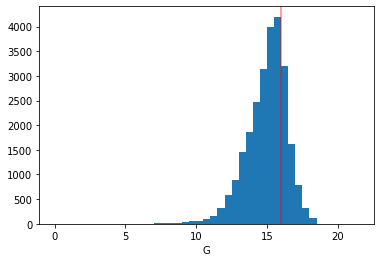

In [30]:
import matplotlib.pyplot as pl
pl.hist(d['phot_g_mean_mag'][finite_mag],bins=np.arange(0,22,0.5));
pl.xlabel('G');
pl.axvline(BRIGHT_TIME_BRIGHT_LIMIT,c='r',alpha=0.5);

Adjust to secondary target data model:

In [31]:
output = d['ra','dec','source_id'][bright_time_targets]
output.rename_columns(['ra','dec','source_id'],['RA','DEC','REF_ID'])
output.add_column(Column(np.repeat(False,len(output)),'OVERRIDE'))
output.add_column(Column(np.zeros(len(output),dtype=np.float32),'PMRA'))
output.add_column(Column(np.zeros(len(output),dtype=np.float32),'PMDEC'))
output.add_column(Column(np.repeat(REF_CAT,len(output)),'REF_CAT'))
output.add_column(Column(np.repeat(REF_EPOCH,len(output)),'REF_EPOCH'))

Add header:

In [32]:
output.meta['VRAWDATA'] = int(os.path.abspath(input_path).split(os.path.sep)[-3])

In [33]:
output[0:3]

RA,DEC,REF_ID,OVERRIDE,PMRA,PMDEC,REF_CAT,REF_EPOCH
float64,float64,int64,bool,float32,float32,str1,str6
100.311522420448,-16.3987159593436,2946947833984773120,False,0.0,0.0,G,2015.5
100.348434870331,-16.555366908798,2946751880397315968,False,0.0,0.0,G,2015.5
100.268863521503,-16.505217609574,2946940137403408256,False,0.0,0.0,G,2015.5


Write output:

In [35]:
print('Writing {:d} rows of output to {}'.format(len(output),os.path.abspath(output_path)))
output.write(output_path,overwrite=True)

Writing 6036 rows of output to /global/projecta/projectdirs/desi/external/mws/sv/MWS_CALIB_GAIAESO/1/indata/MWS_CALIB_GAIAESO.fits
